# Table of Content
1. Import libraries and dataset
2. Data wrangling for time series analysis
3. Line Charts
4. Decomposition
5. Testing for Stationarity
6. Stationarizing data
7. Export dataframe

# 1. Import libraries and dataset

In [2]:
# Importing libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
import datetime

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') 

In [3]:
# Configure API key
quandl.ApiConfig.api_key = 'QZDM34qrvdyuUkABmszy'

In [4]:
# Defining path for data import
path = r'/Users/frederikeschulz-mullensiefen/Desktop/Masterfolder_Hotel Bookings'

In [5]:
# Import cleaned hotel bookings dataset 
df_bookings = pd.read_pickle(os.path.join(path, '02_Data', 'Prepared Data', 'hotel_bookings_cleaned2_wrangled.pkl'))

In [6]:
# Display settings for graphs and tables
pd.set_option('display.max_columns', None)
%matplotlib inline

In [7]:
df_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,reservation_status,total_guests,total_number_nights
2,Resort Hotel,0,7,2015,July,27,0,1,1,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,75.0,Check-Out,1.0,1
3,Resort Hotel,0,13,2015,July,27,0,1,1,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,75.0,Check-Out,1.0,1
4,Resort Hotel,0,14,2015,July,27,0,2,2,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,98.0,Check-Out,2.0,2
5,Resort Hotel,0,14,2015,July,27,0,2,2,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,98.0,Check-Out,2.0,2
6,Resort Hotel,0,0,2015,July,27,0,2,2,0.0,0,BB,PRT,0,0,0,0,No Deposit,0,Transient,107.0,Check-Out,2.0,2


# 2. Data wrangling for time series analysis

#### 1. Creating date column

In [8]:
# Create a new column with dates from arrival year and week columns

# Define a function that takes a week number and year and returns a date
def week_to_date(week, year):
    try:
        # Get the first day of the week (Monday) for the given week and year
        date = datetime.date.fromisocalendar(year, week, 1)
    except ValueError as e:
        # Handle the case where the week number is invalid
        if "Invalid week" in str(e):
            # Adjust the week to 52 if it exceeds the valid range
            date = datetime.date.fromisocalendar(year, 52, 1)
        else:
            raise e
    return date

# Apply the function to the dataframe and create a new column with the date
df_bookings["date"] = df_bookings.apply(lambda row: week_to_date(row["arrival_date_week_number"], row["arrival_date_year"]), axis=1)

In [9]:
df_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,reservation_status,total_guests,total_number_nights,date
2,Resort Hotel,0,7,2015,July,27,0,1,1,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,75.0,Check-Out,1.0,1,2015-06-29
3,Resort Hotel,0,13,2015,July,27,0,1,1,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,75.0,Check-Out,1.0,1,2015-06-29
4,Resort Hotel,0,14,2015,July,27,0,2,2,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,98.0,Check-Out,2.0,2,2015-06-29
5,Resort Hotel,0,14,2015,July,27,0,2,2,0.0,0,BB,GBR,0,0,0,0,No Deposit,0,Transient,98.0,Check-Out,2.0,2,2015-06-29
6,Resort Hotel,0,0,2015,July,27,0,2,2,0.0,0,BB,PRT,0,0,0,0,No Deposit,0,Transient,107.0,Check-Out,2.0,2,2015-06-29


#### 2. Creating dataframe with aggregated values

In [10]:
# Grouping bookings by date
booking_count = df_bookings.groupby('date')['date'].count()

In [11]:
# Grouping average adr by date
avg_adr = df_bookings.groupby('date')['adr'].mean()

In [12]:
# Creating new dataframe with aggregated values by date
df_time = pd.DataFrame({'date': booking_count.index, 'booking_count': booking_count.values, 'avg_adr': avg_adr.values})

In [13]:
df_time.head()

,date,booking_count,avg_adr
0,2015-06-29,353,89.698952
1,2015-07-06,477,93.510461
2,2015-07-13,688,100.970465
3,2015-07-20,762,98.114108
4,2015-07-27,569,114.374868


In [14]:
# Changing date into correct datatype
df_time['date'] = pd.to_datetime(df_time['date'])

In [15]:
# Set the 'date' column as the index
df_time.set_index('date', inplace=True)

In [16]:
# Check for missing values 
df_time.isnull().sum() 

booking_count    0
avg_adr          0
dtype: int64

In [17]:
# Check for duplicates
dups = df_time.duplicated()
dups.sum()

0

#### 3. Create subsets for city and resort hotel and create aggregated values for each by date

In [18]:
# Create subset for only city hotel
df_city = df_bookings[(df_bookings['hotel'] == 'City Hotel') == True]

In [19]:
# Create subset for only resort hotel
df_resort = df_bookings[(df_bookings['hotel'] == 'Resort Hotel') == True]

In [20]:
# Grouping bookings by date
city_booking_count = df_city.groupby('date')['date'].count()
city_avg_adr = df_city.groupby('date')['adr'].mean()

In [21]:
# Creating new dataframe with aggregated values by date
df_city_time = pd.DataFrame({'date': city_booking_count.index, 'booking_count': city_booking_count.values, 'avg_adr': city_avg_adr.values})

In [22]:
# Changing date into correct datatype
df_city_time['date'] = pd.to_datetime(df_city_time['date'])

In [23]:
# Set the 'date' column as the index
df_city_time.set_index('date', inplace=True)

In [24]:
df_city_time.head()

,booking_count,avg_adr
date,,
2015-06-29,182,78.165879
2015-07-06,214,70.247336
2015-07-13,351,74.207350
2015-07-20,451,67.062528
2015-07-27,230,65.931957


In [25]:
# Check for missing values 
df_city_time.isnull().sum() 

booking_count    0
avg_adr          0
dtype: int64

In [26]:
# Check for duplicates
dups1 = df_city_time.duplicated()
dups1.sum()

0

In [27]:
# Grouping bookings by date
resort_booking_count = df_resort.groupby('date')['date'].count()
resort_avg_adr = df_resort.groupby('date')['adr'].mean()

In [28]:
# Creating new dataframe with aggregated values by date
df_resort_time = pd.DataFrame({'date': resort_booking_count.index, 'booking_count': resort_booking_count.values, 'avg_adr': resort_avg_adr.values})

In [29]:
# Changing date into correct datatype
df_resort_time['date'] = pd.to_datetime(df_resort_time['date'])

In [30]:
# Set the 'date' column as the index
df_resort_time.set_index('date', inplace=True)

In [31]:
df_resort_time.head()

,booking_count,avg_adr
date,,
2015-06-29,171,101.973918
2015-07-06,263,112.439392
2015-07-13,337,128.845401
2015-07-20,311,143.143891
2015-07-27,339,147.241740


In [32]:
# Check for missing values 
df_resort_time.isnull().sum() 

booking_count    0
avg_adr          0
dtype: int64

In [33]:
# Check for duplicates
dups2 = df_resort_time.duplicated()
dups2.sum()

0

# 3. Line charts

#### 1. Number of bookings

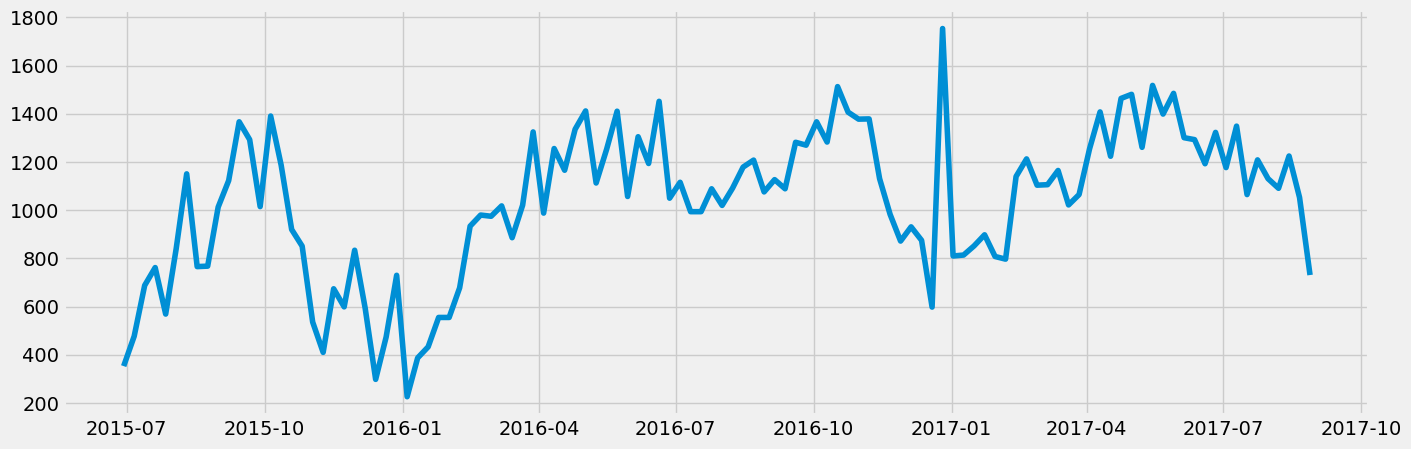

In [34]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_time['booking_count'])

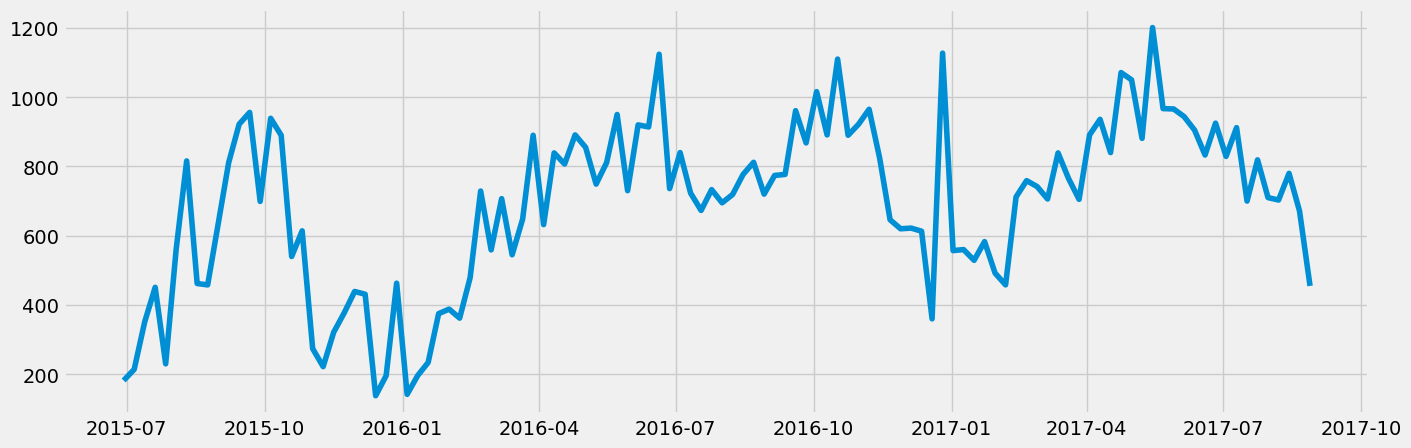

In [35]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_city_time['booking_count'])

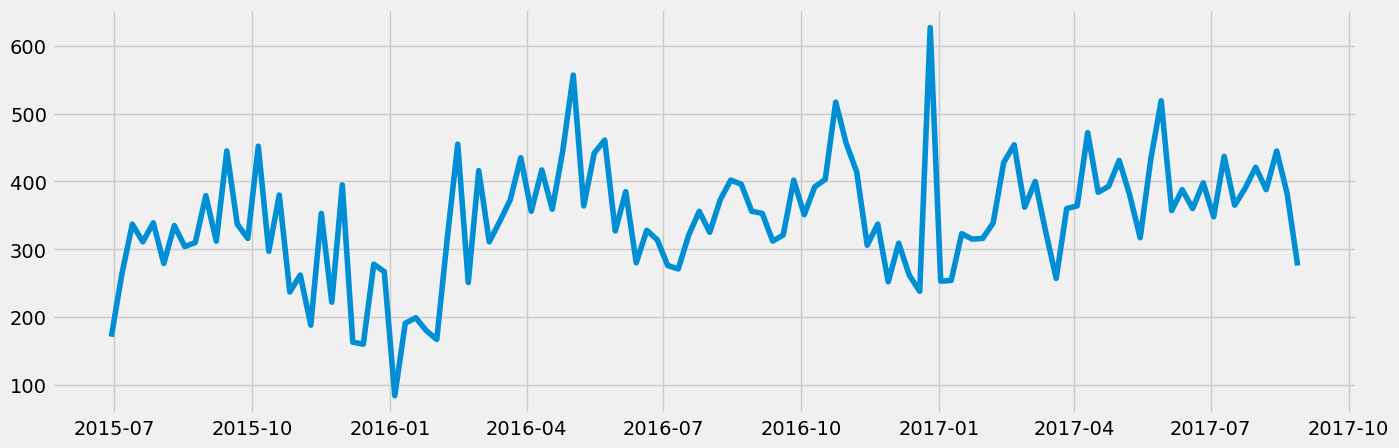

In [36]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_resort_time['booking_count'])

#### 2. Average adr

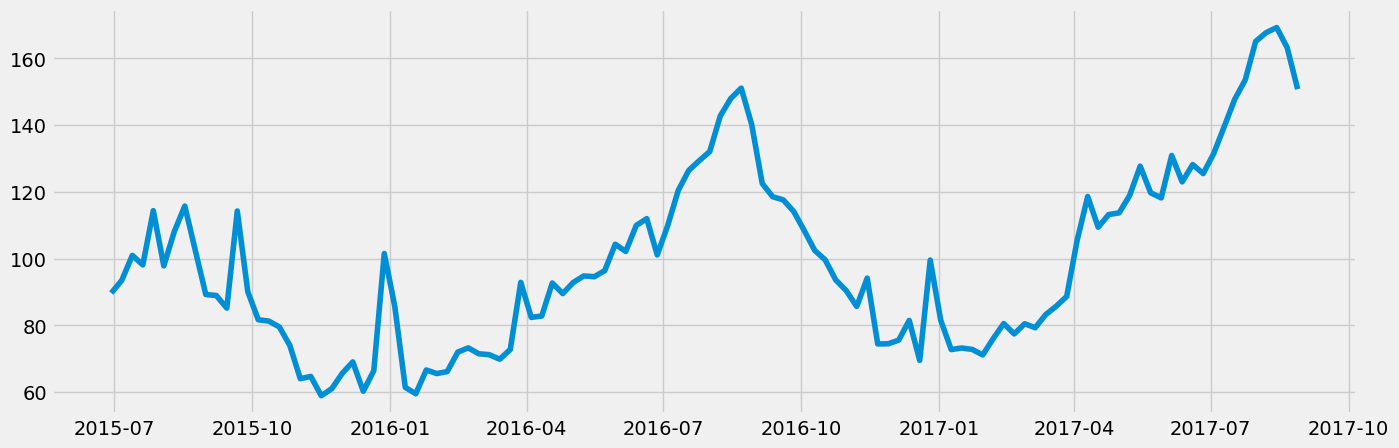

In [37]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_time['avg_adr'])

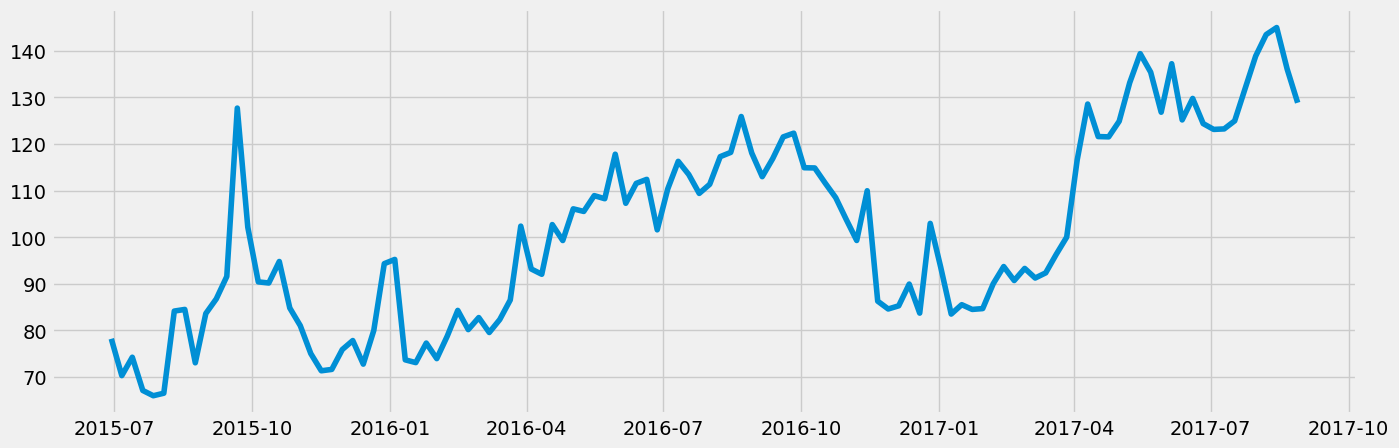

In [38]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_city_time['avg_adr'])

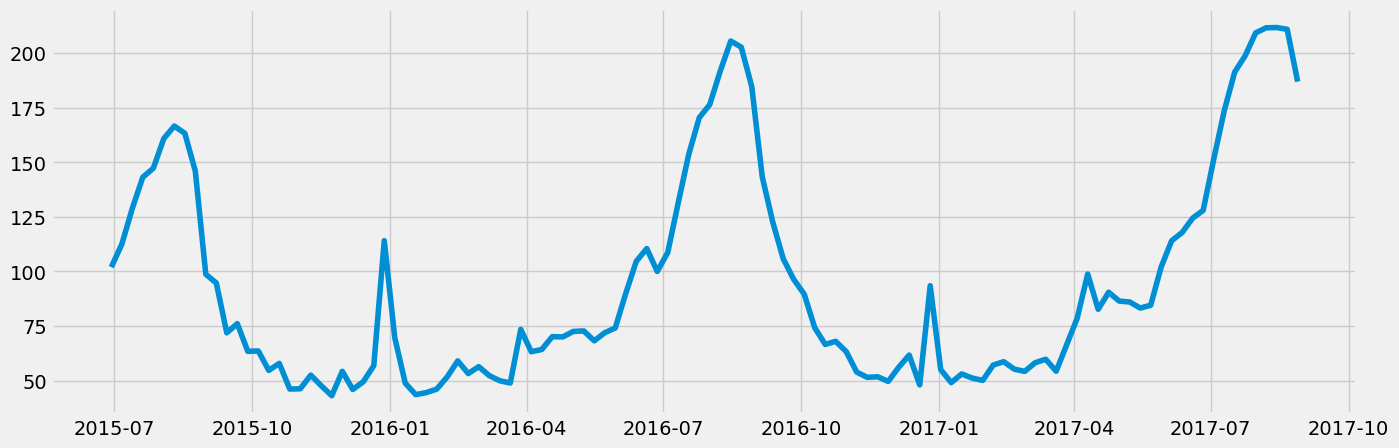

In [39]:
# Plot 
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_resort_time['avg_adr'])

# 4. Decomposition

#### Bookings

In [40]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_time['booking_count'], model='additive')

In [41]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

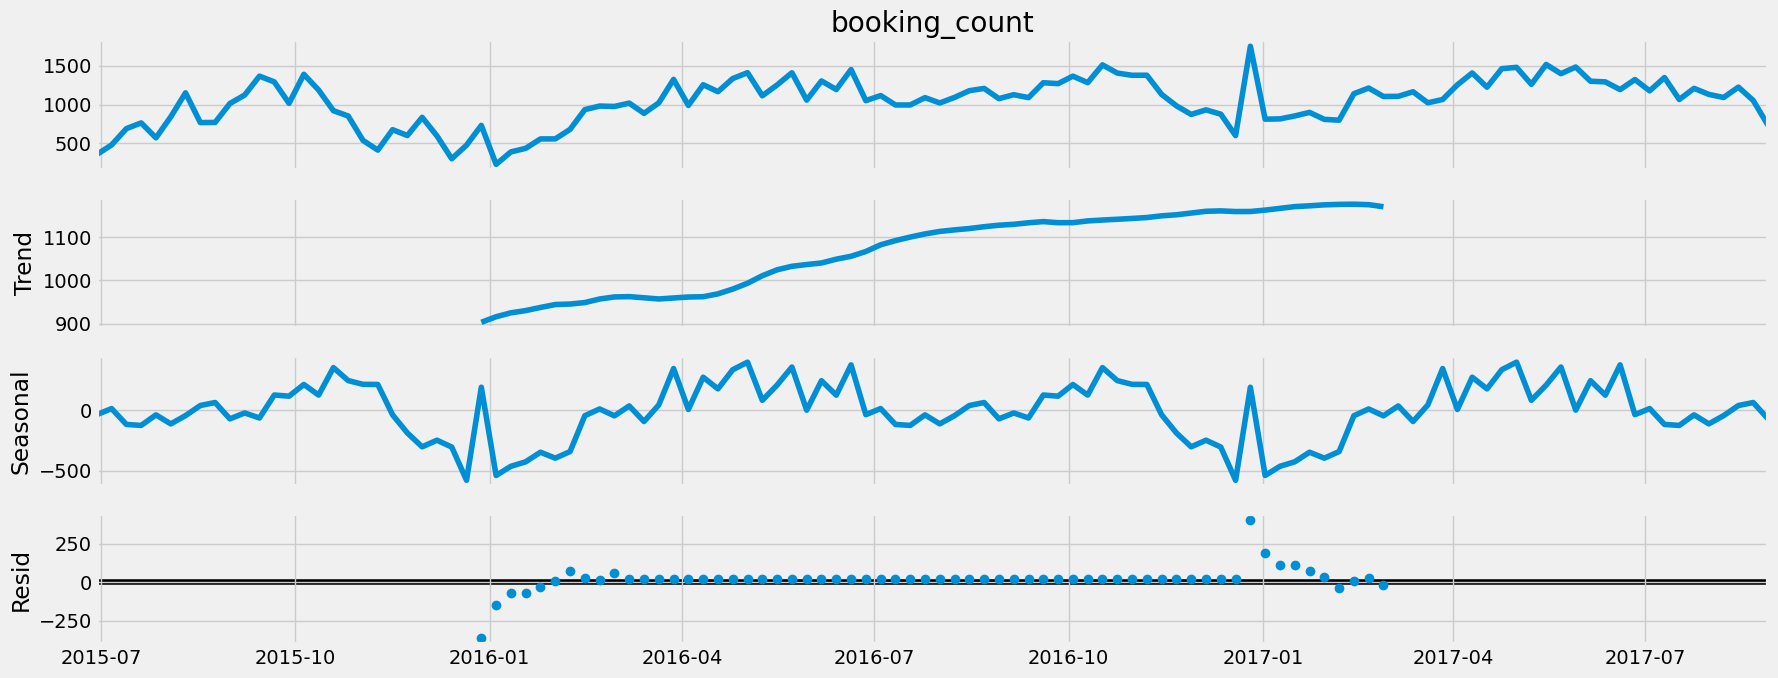

In [42]:
# Plot the separate components

decomposition.plot()
plt.show()

In [43]:
# Decompose the time series using an additive model
decomposition_city = sm.tsa.seasonal_decompose(df_city_time['booking_count'], model='additive')

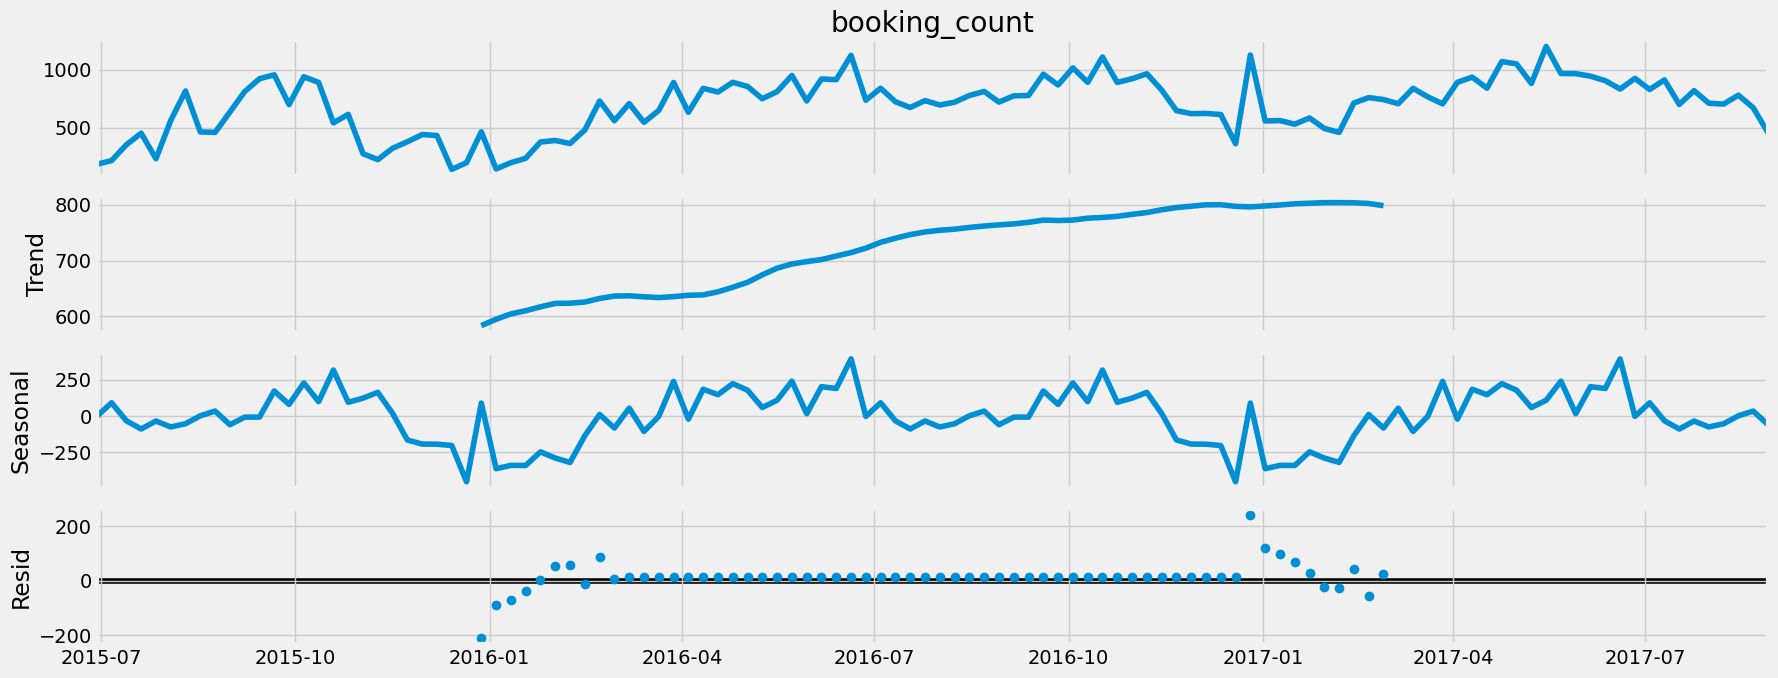

In [44]:
# Plot the separate components
decomposition_city.plot()
plt.show()

In [45]:
# Decompose the time series using an additive model
decomposition_resort = sm.tsa.seasonal_decompose(df_resort_time['booking_count'], model='additive')

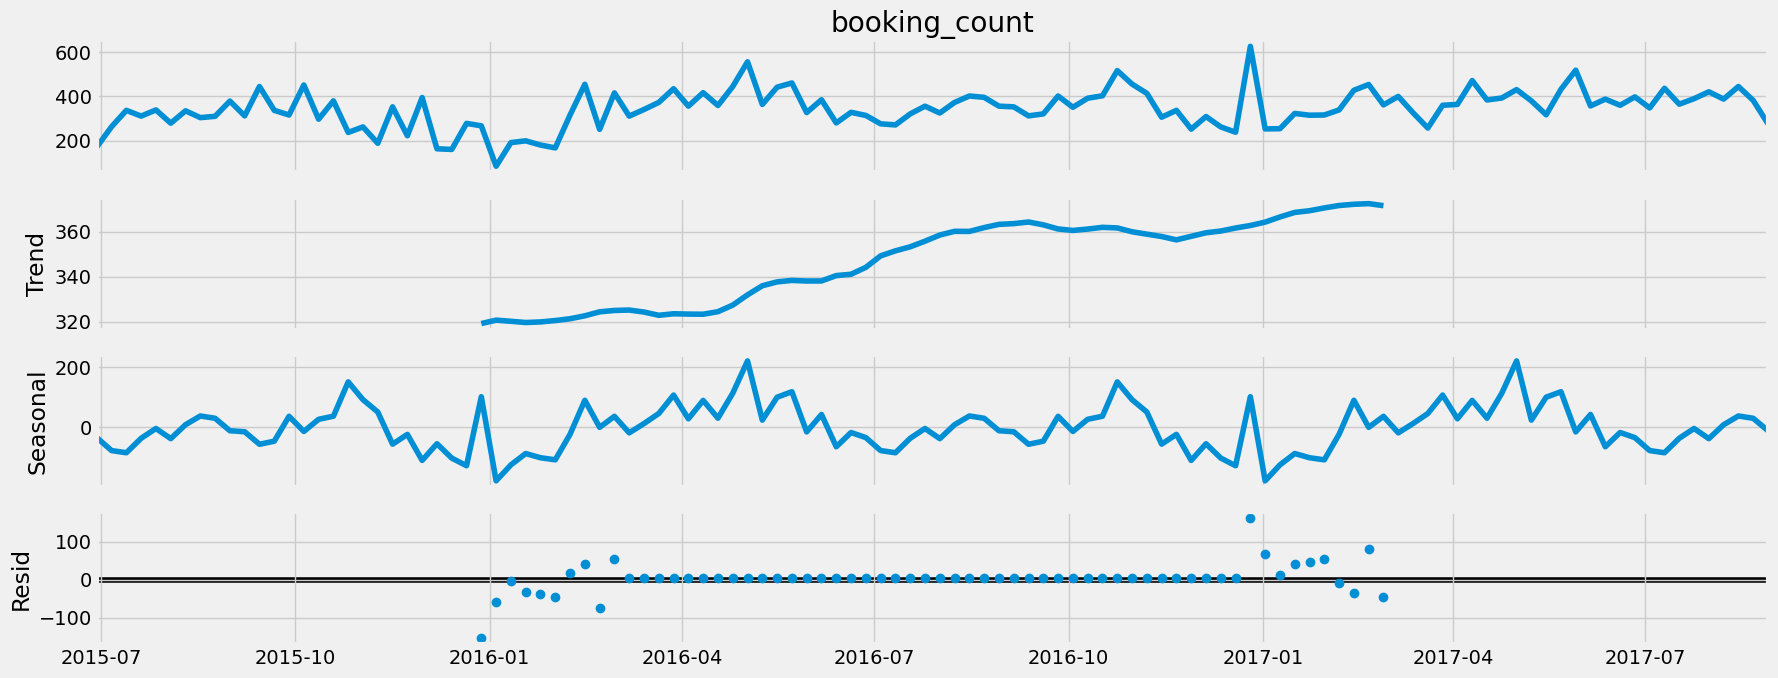

In [46]:
# Plot the separate components
decomposition_resort.plot()
plt.show()

###### Analysis decomposition bookings

Trend:
As can be seen in the graphs above, all three, the city, resort, and total dataset all seem to have a general upward trend from January 2016 to January 2017, indicating that for both the city and the resort hotel there is a general increase of bookings. 

Seasonality:
With regard to the city hotel, there seem to be recurring peaks in spring time (around April), summer time (around June), and autumn time(around November), as well as recurring lows in winter (in January). The highest recurring peaks are in summer. 
With regard to the resort hotel, there are recurring peaks around May and November, and recurring lows in January. 

Noise:
For both the city and resort hotel, there does seem to be noise in the time from January - February in both years, which means that these months do not seem to be very stable. 

#### Average daily rate

In [47]:
# Decompose the time series using an additive model
decomposition_avgadr = sm.tsa.seasonal_decompose(df_time['avg_adr'], model='additive')

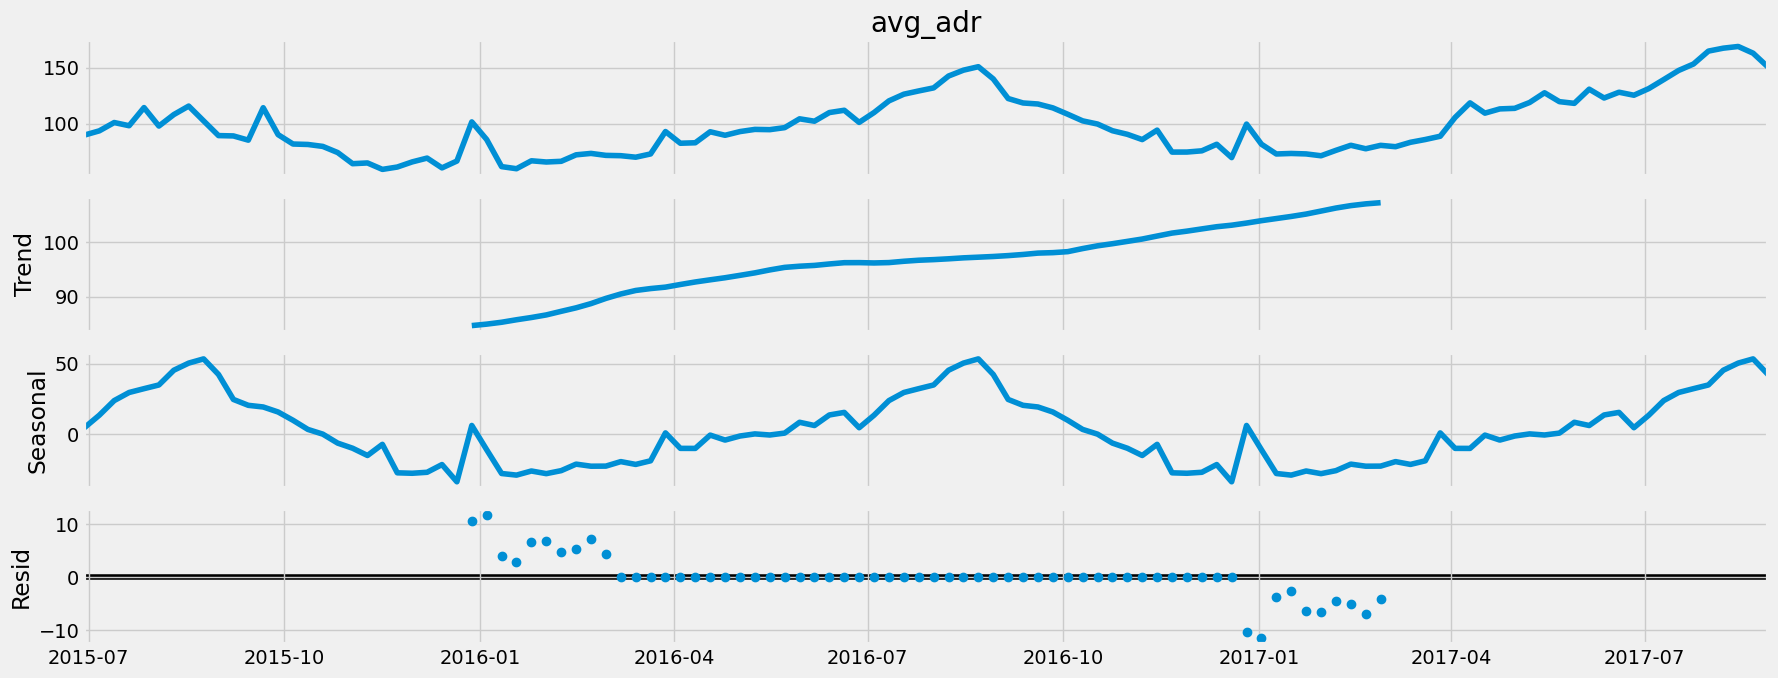

In [48]:
# Plot the separate components
decomposition_avgadr.plot()
plt.show()

In [49]:
# Decompose the time series using an additive model
decomposition_city_avgadr = sm.tsa.seasonal_decompose(df_city_time['avg_adr'], model='additive')

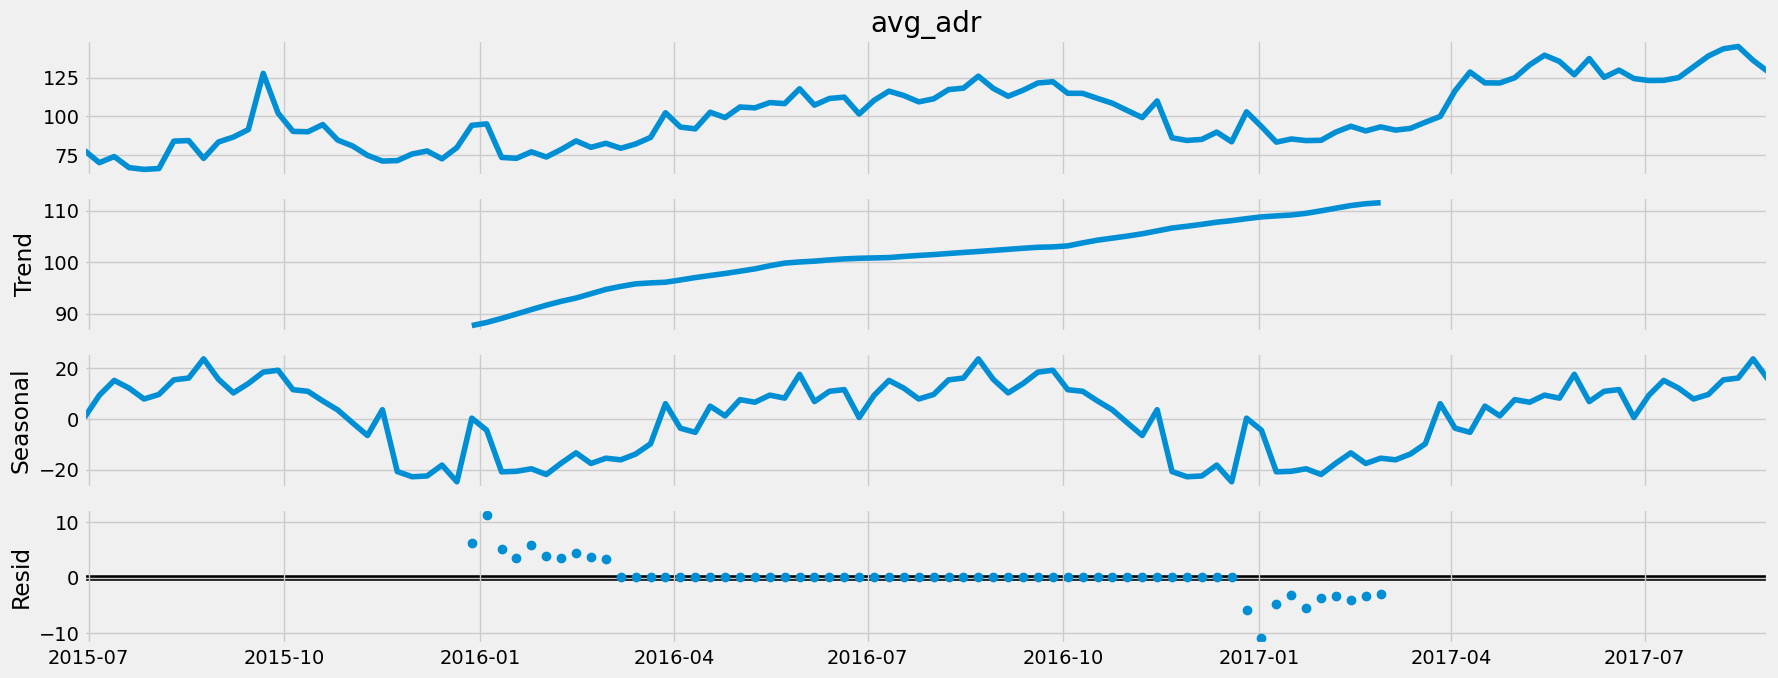

In [50]:
# Plot the separate components
decomposition_city_avgadr.plot()
plt.show()

In [51]:
# Decompose the time series using an additive model
decomposition_resort_avgadr = sm.tsa.seasonal_decompose(df_resort_time['avg_adr'], model='additive')

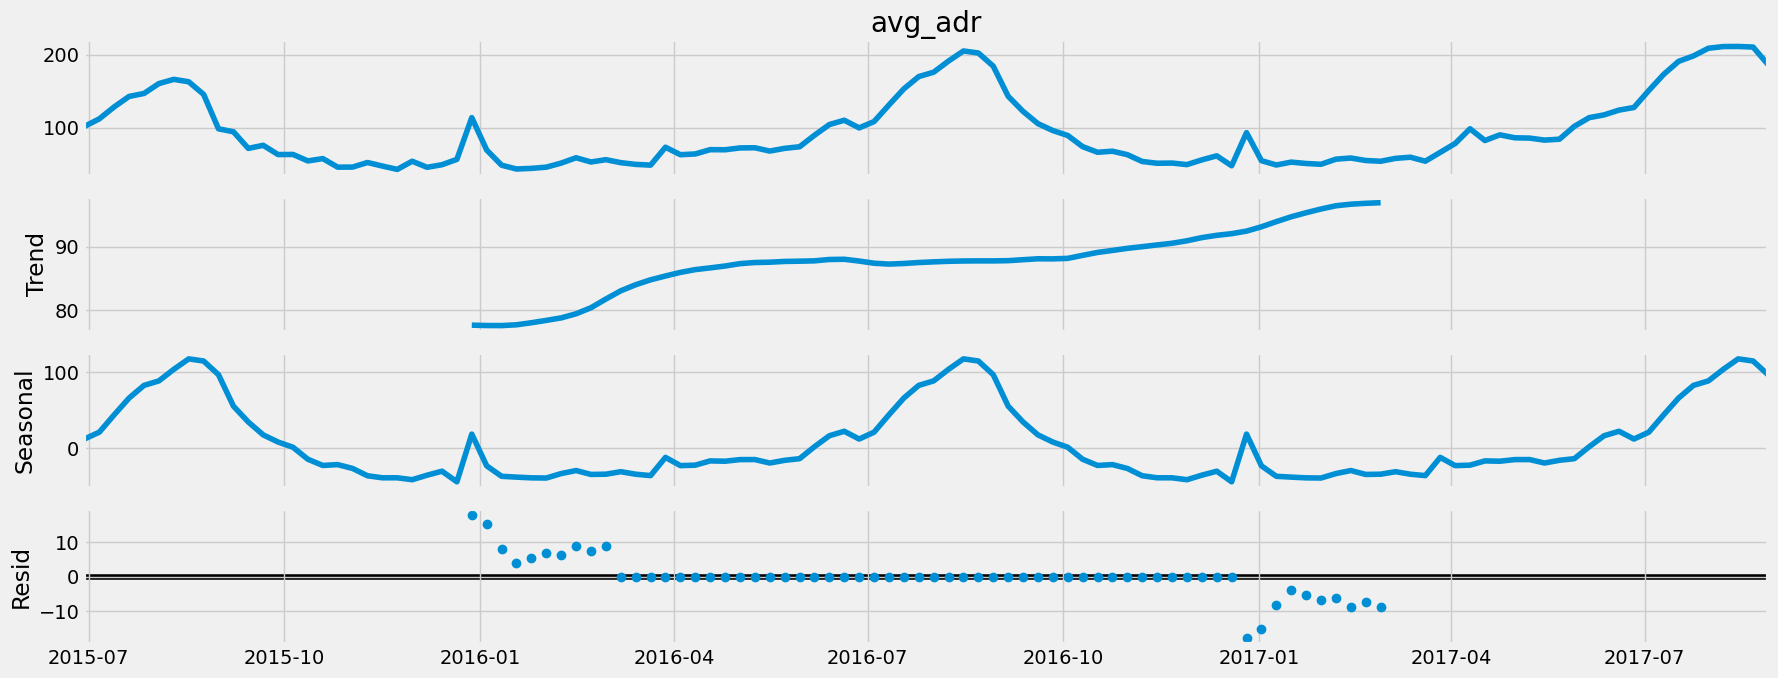

In [52]:
# Plot the separate components
decomposition_resort_avgadr.plot()
plt.show()

##### Analysis decomposition adr

Trend: As can be seen in the graphs above, all three, the city, resort, and total dataset all seem to have a general upward trend from January 2016 to January 2017, indicating that for both the city and the resort hotel there is a general increase of the average daily rate (meaning more profit).

Seasonality: Here, the curves look quite different for the city and resort hotel. While the city hotel's seasonality curve is quite jagged, the resort hotel's seasonality curve is smooth. 
However, both hotels' adr recurringly peaks around August and September and has recurring lows in December to January. One possible explanation may be that the hotels increase prices in peak travel months like August and September (and thereby have higher profits) and decrease prices in winter months when there is less travel demand (and thereby have lower profits). 

Noise: For both the city and resort hotel, there does seem to be noise in the time from January - February in both years.

# 5. Testing for Stationarity

#### Bookings

In [53]:
# Dickey-Fuller test for both hotels dataset

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_time['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.579785
p-value                          0.097248
Number of Lags Used              2.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


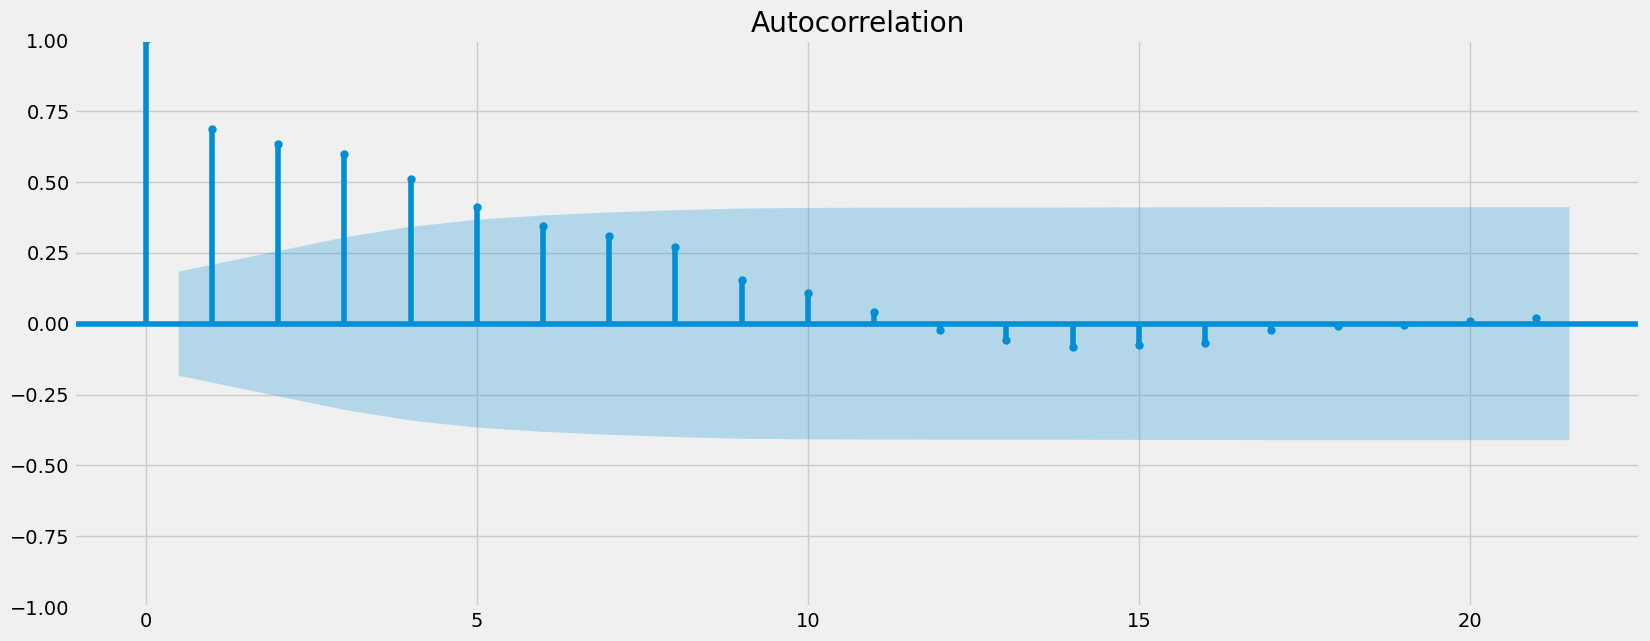

In [54]:
# Check out a plot of autocorrelations of both hotels

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_time['booking_count'])
plt.show()

##### Analysis both hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

In [55]:
# Dickey-Fuller test for city hotel

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_city_time['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.571083
p-value                          0.099122
Number of Lags Used              2.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


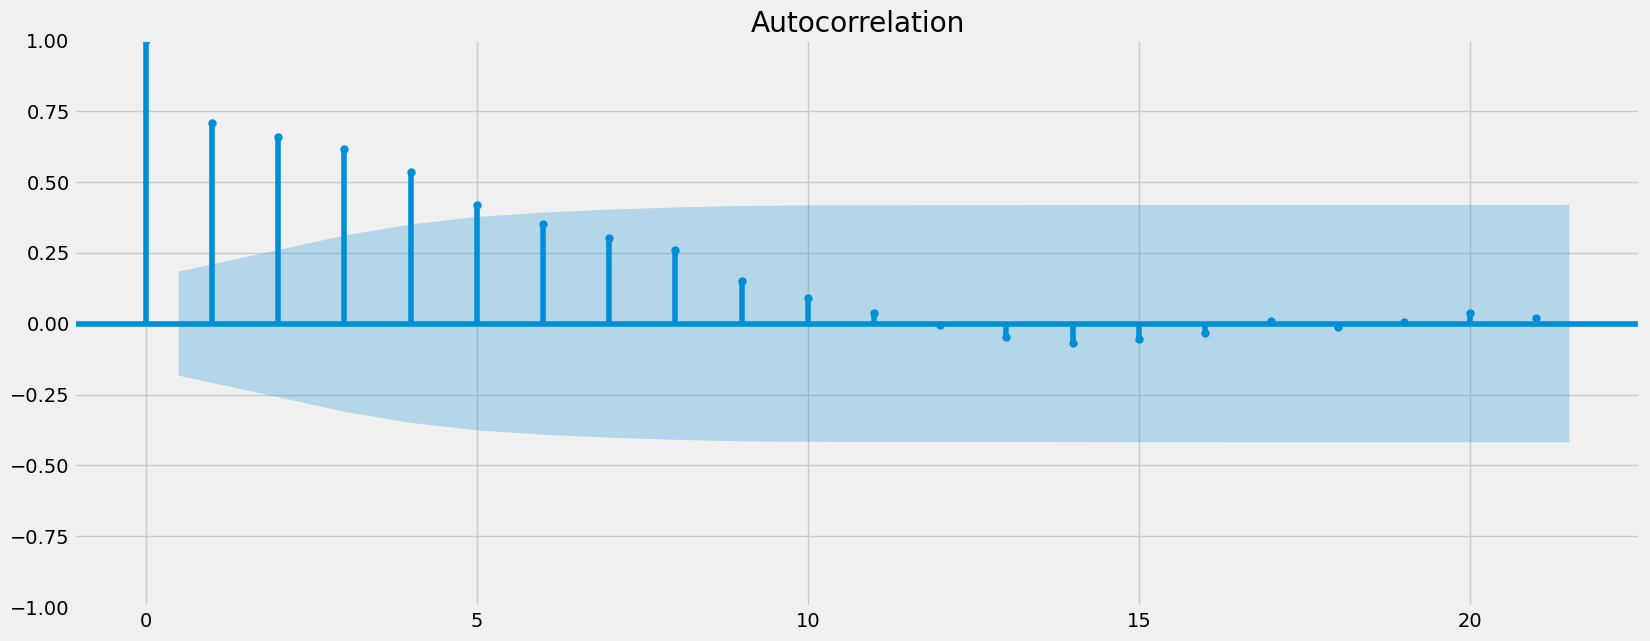

In [56]:
# Check out a plot of autocorrelations of both hotels

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_city_time['booking_count'])
plt.show()

##### Analysis city hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

In [57]:
# Dickey-Fuller test for resort hotel

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_resort_time['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.471478
p-value                          0.008751
Number of Lags Used              2.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


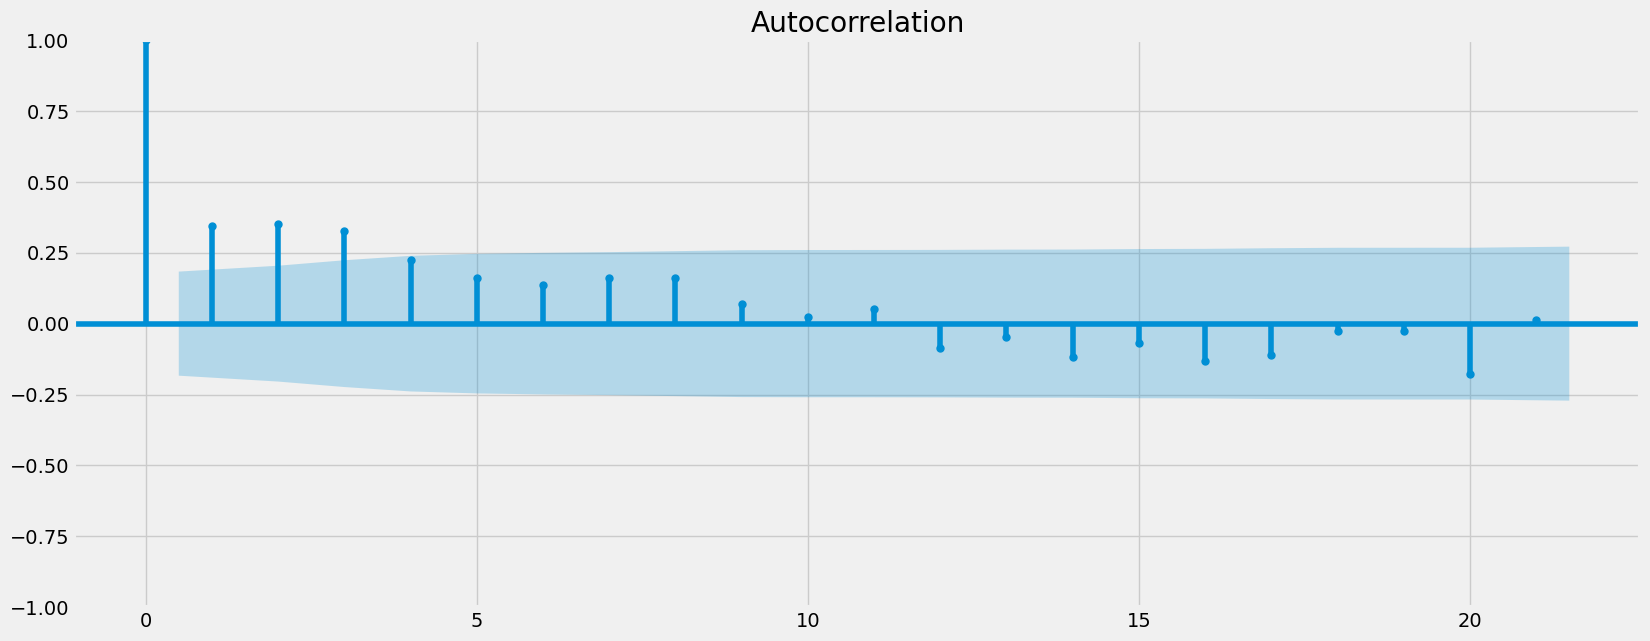

In [58]:
# Check out a plot of autocorrelations of both hotels

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_resort_time['booking_count'])
plt.show()

##### Analysis resort hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

#### Average daily rate

In [59]:
# Dickey-Fuller test for both hotels dataset

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_time['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.454746
p-value                          0.555768
Number of Lags Used              0.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


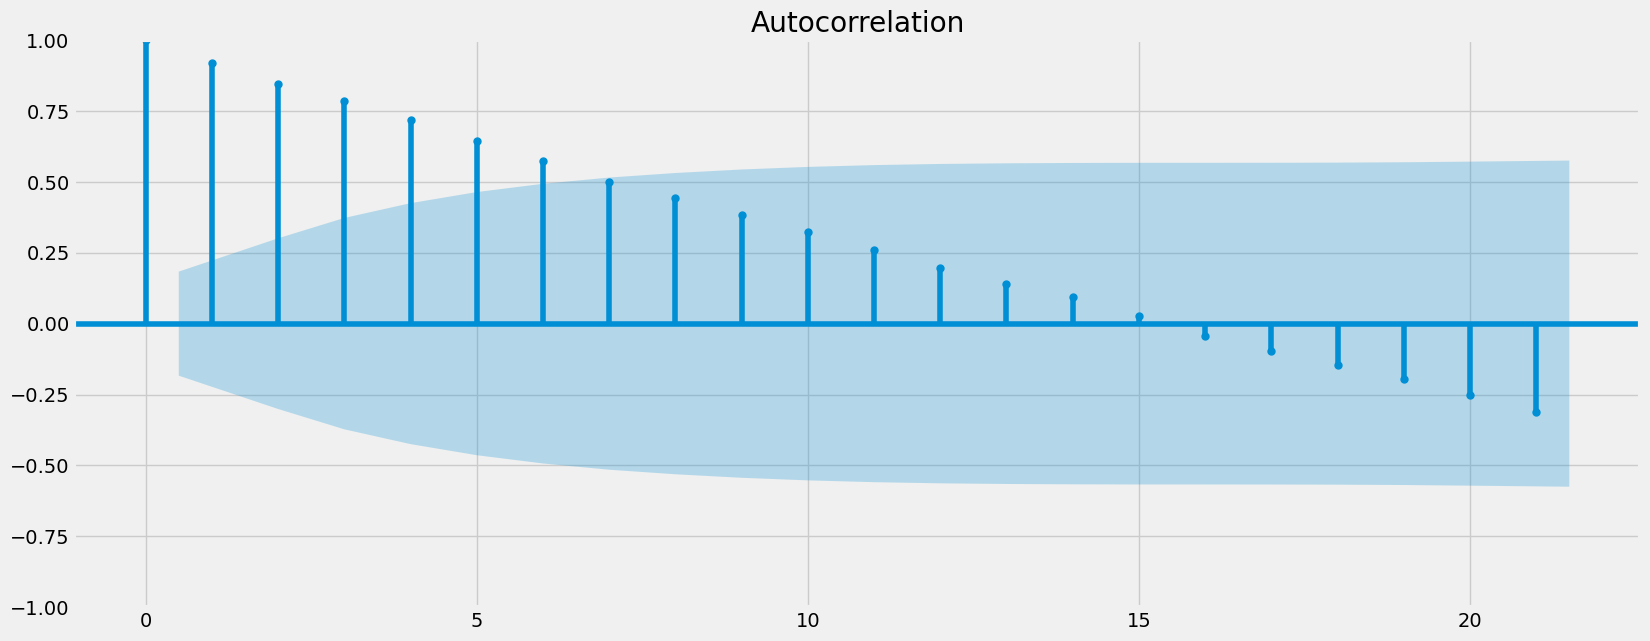

In [60]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_time['avg_adr'])
plt.show()

#####  Analysis both hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

In [61]:
# Dickey-Fuller test for city hotel

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_city_time['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.138945
p-value                          0.229145
Number of Lags Used              0.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


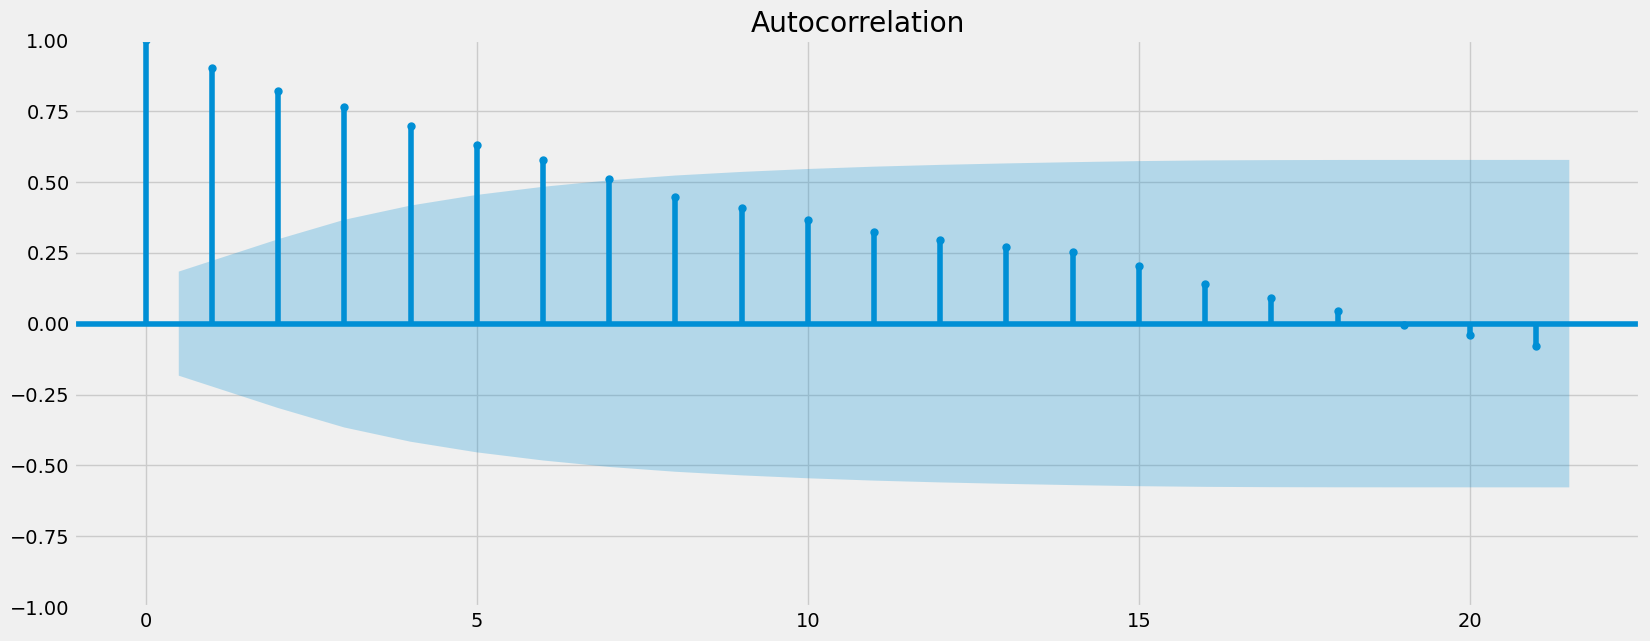

In [62]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_city_time['avg_adr'])
plt.show()

#####  Analysis city hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

In [63]:
# Dickey-Fuller test for resort hotel

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_resort_time['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.052166
p-value                          0.733766
Number of Lags Used              0.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


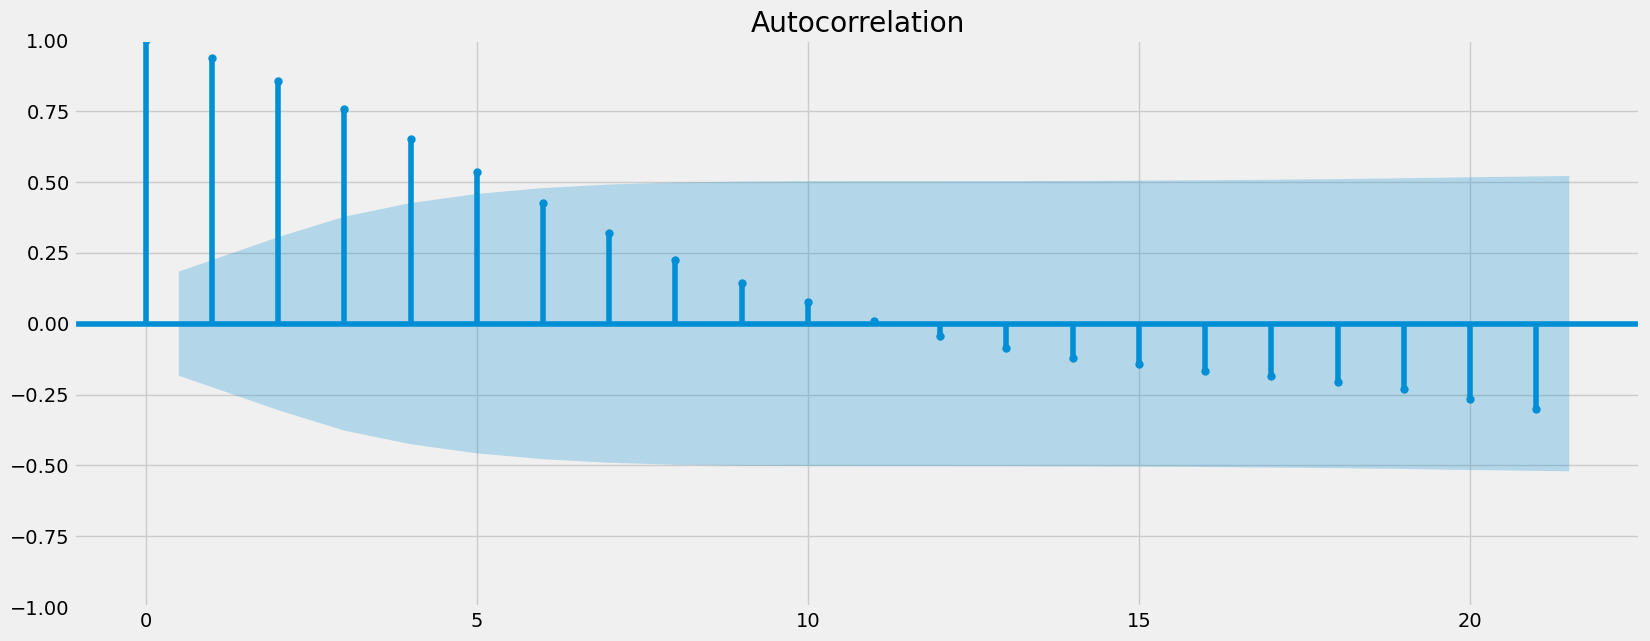

In [64]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_resort_time['avg_adr'])
plt.show()

#####  Analysis resort hotel data stationarity
The null hypothesis can't be rejected as the test statistic is not lower than the critical values. As there are lags outside the blue edge of the confidence interval, there are lags that are significantly correlated with each other.

# 6. Stationarizing data

#### Stationarizing both hotels dataset

In [65]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = df_time - df_time.shift(1) 

In [66]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff.dropna(inplace = True) 

In [67]:
data_diff.head()

,booking_count,avg_adr
date,,
2015-07-06,124.0,3.811509
2015-07-13,211.0,7.460004
2015-07-20,74.0,-2.856358
2015-07-27,-193.0,16.260761
2015-08-03,271.0,-16.570118


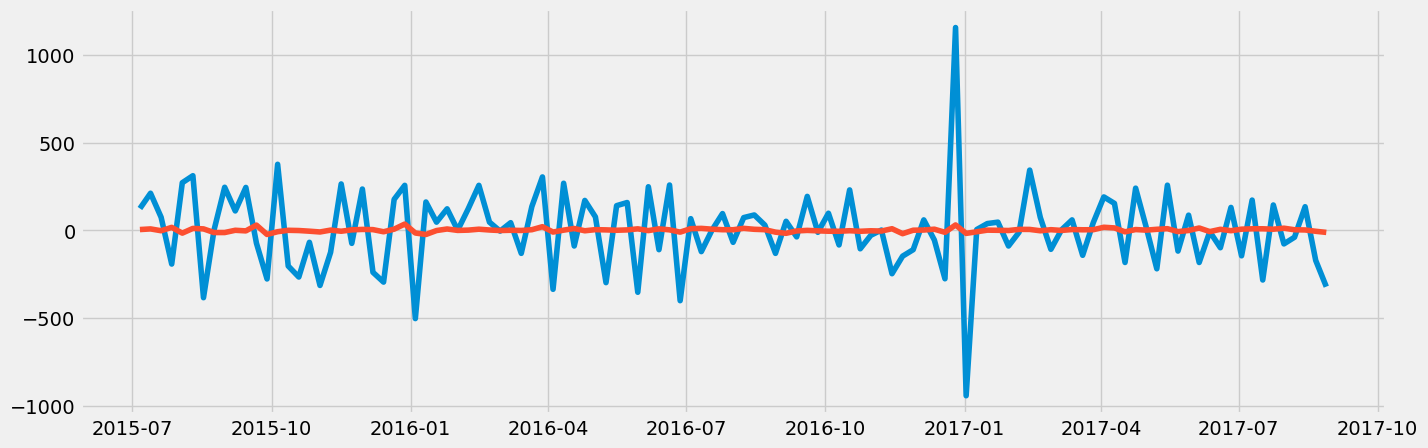

In [68]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [69]:
dickey_fuller(data_diff['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.112582e+01
p-value                        3.376443e-20
Number of Lags Used            1.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


In [70]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff2 = data_diff - data_diff.shift(1) 

In [71]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff2.dropna(inplace = True) 

In [72]:
data_diff2.head()

,booking_count,avg_adr
date,,
2015-07-13,87.0,3.648495
2015-07-20,-137.0,-10.316361
2015-07-27,-267.0,19.117118
2015-08-03,464.0,-32.830879
2015-08-10,40.0,26.875142


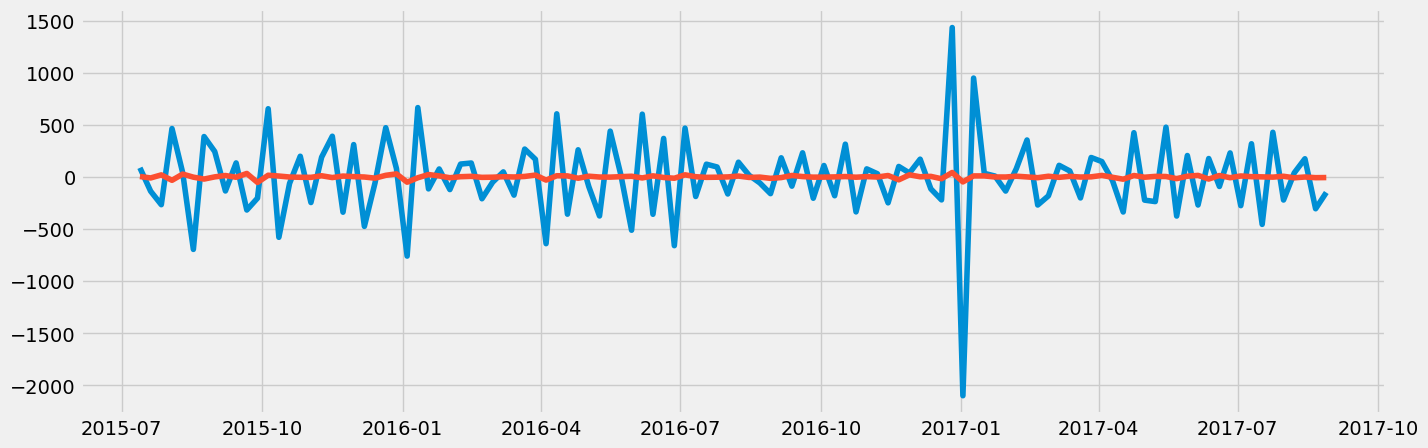

In [73]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [74]:
dickey_fuller(data_diff2['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -7.347649e+00
p-value                        1.025540e-10
Number of Lags Used            6.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


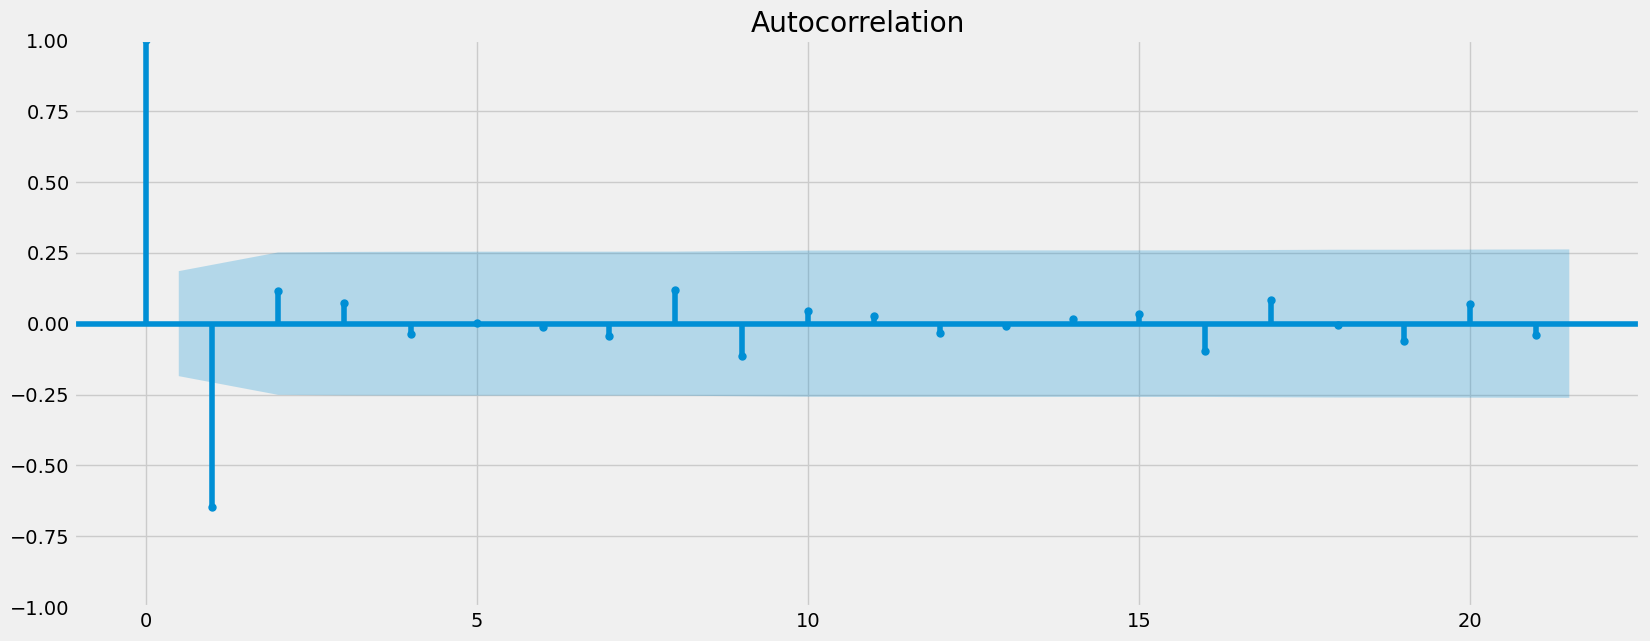

In [75]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff2['booking_count'])
plt.show()

In [76]:
dickey_fuller(data_diff2['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                -8.709604e+00
p-value                        3.621148e-14
Number of Lags Used            4.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


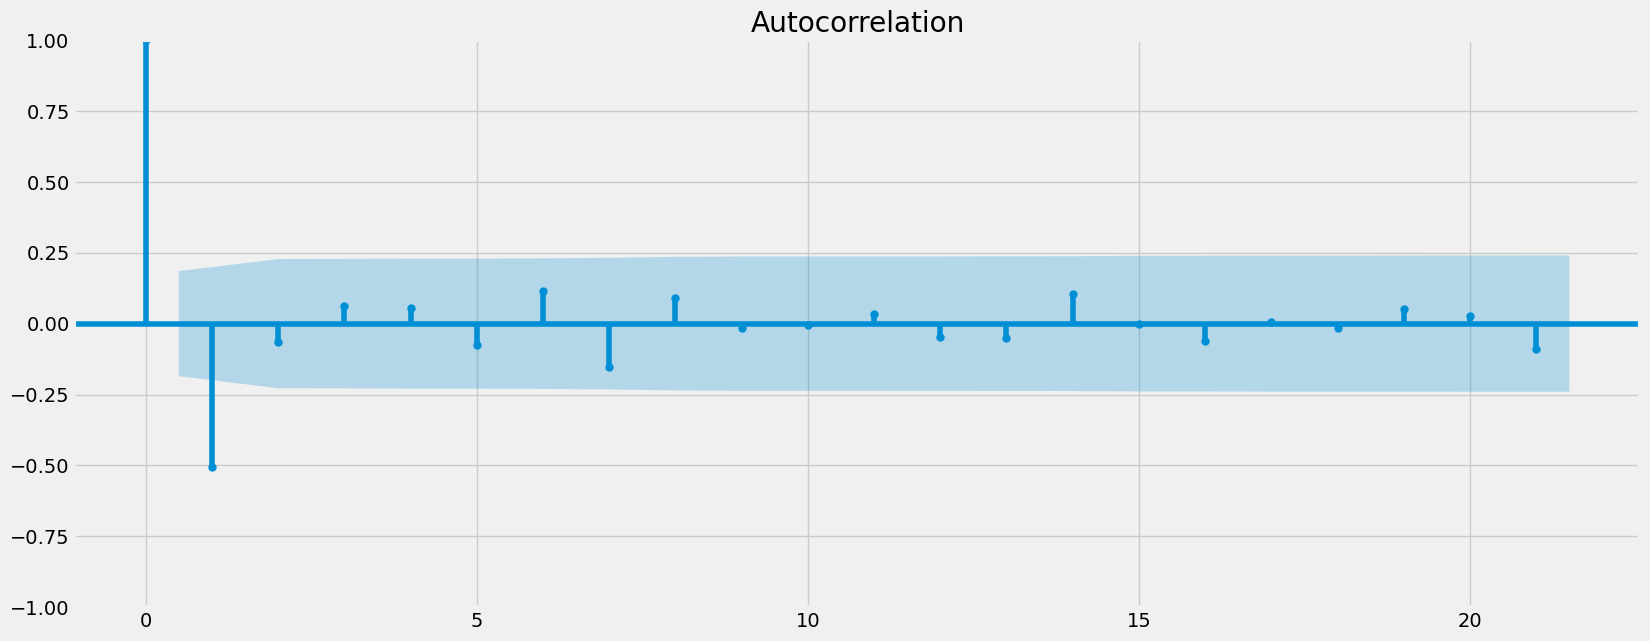

In [77]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff2['avg_adr'])
plt.show()

#### Stationarizing city hotel dataset

In [78]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff_city = df_city_time - df_city_time.shift(1) 

In [79]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff_city.dropna(inplace = True) 

In [80]:
data_diff_city.head()

,booking_count,avg_adr
date,,
2015-07-06,32.0,-7.918543
2015-07-13,137.0,3.960014
2015-07-20,100.0,-7.144823
2015-07-27,-221.0,-1.130571
2015-08-03,331.0,0.539666


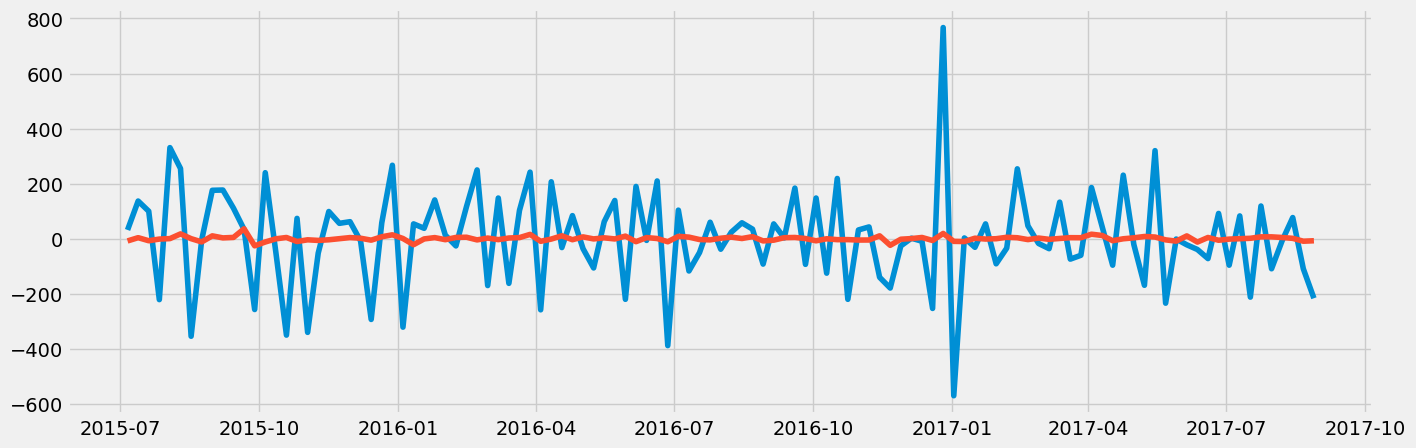

In [81]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_city)

In [82]:
dickey_fuller(data_diff_city['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.105565e+01
p-value                        4.952878e-20
Number of Lags Used            1.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


In [83]:
dickey_fuller(data_diff2['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                -8.709604e+00
p-value                        3.621148e-14
Number of Lags Used            4.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


In [84]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff_city2 = data_diff_city - data_diff_city.shift(1) 

In [85]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff_city2.dropna(inplace = True) 

In [86]:
data_diff_city2.head()

,booking_count,avg_adr
date,,
2015-07-13,105.0,11.878557
2015-07-20,-37.0,-11.104837
2015-07-27,-321.0,6.014252
2015-08-03,552.0,1.670237
2015-08-10,-76.0,17.108957


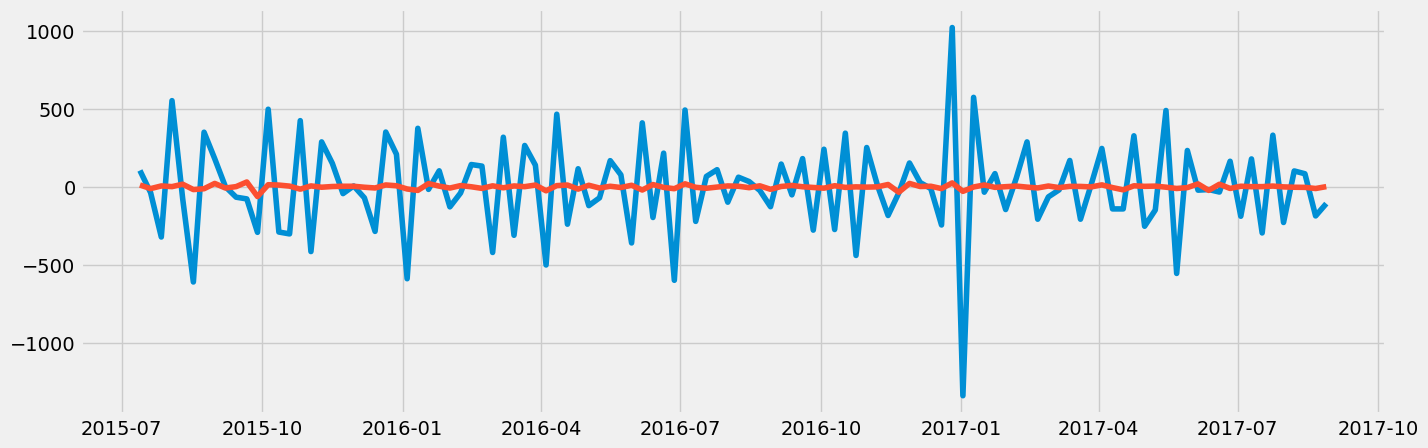

In [87]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_city2)

In [88]:
dickey_fuller(data_diff_city2['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.540166e+00
p-value                        9.390135e-09
Number of Lags Used            7.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


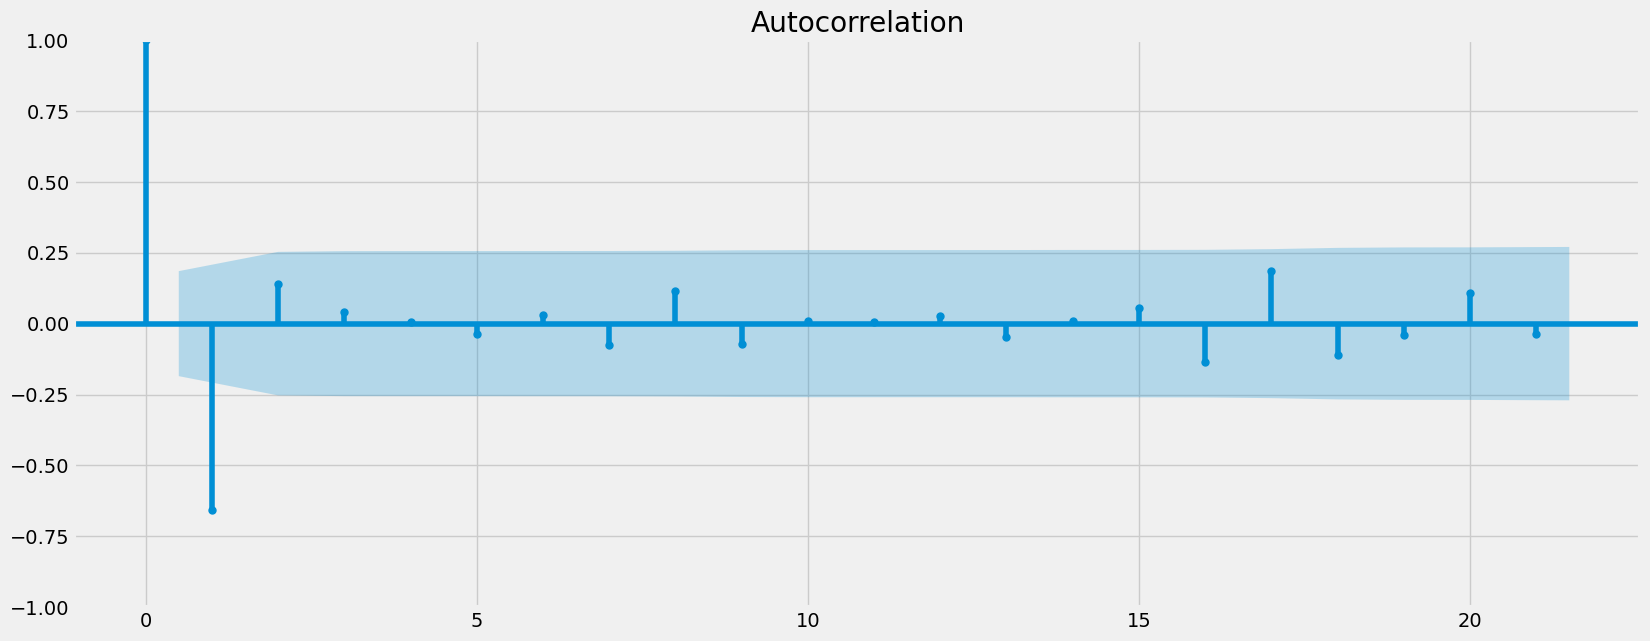

In [89]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_city2['booking_count'])
plt.show()

In [90]:
dickey_fuller(data_diff_city2['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                -8.154992e+00
p-value                        9.472475e-13
Number of Lags Used            5.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


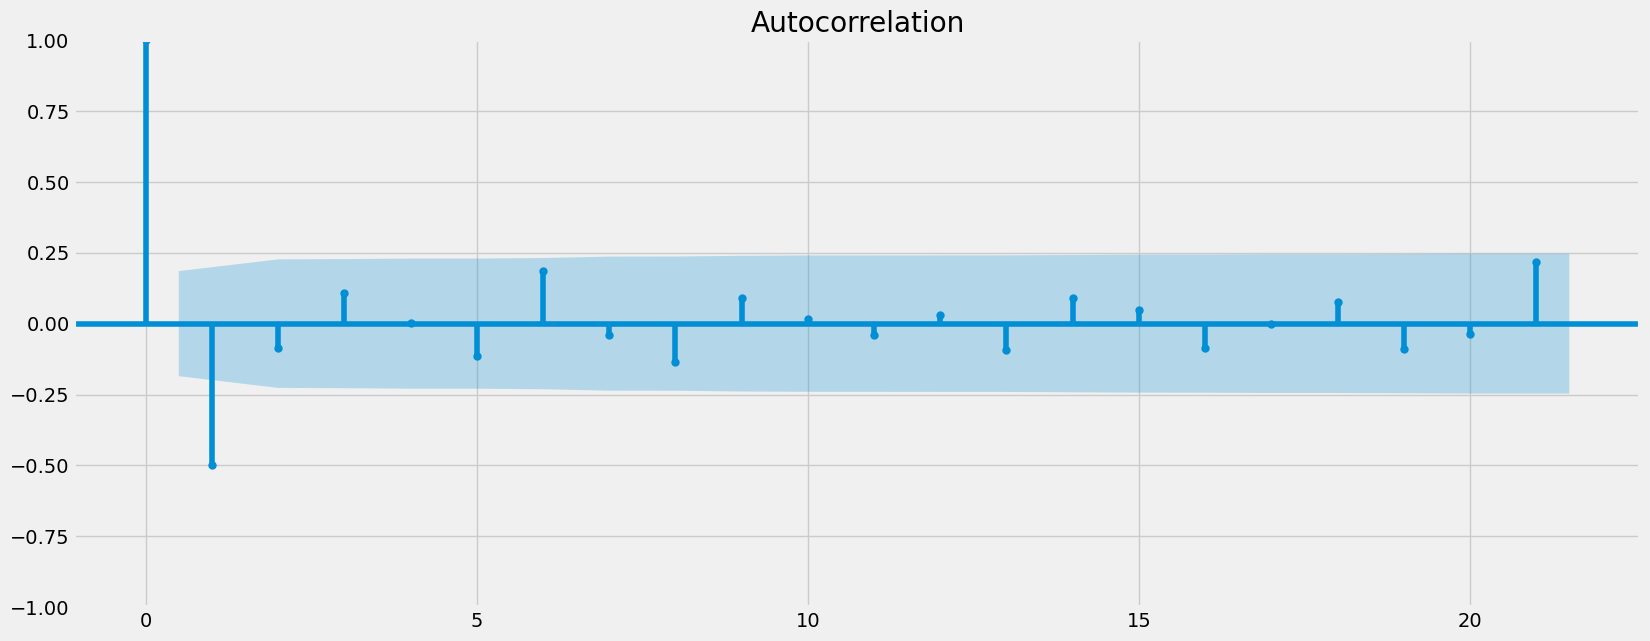

In [91]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_city2['avg_adr'])
plt.show()

#### Stationarizing resort dataset

In [92]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff_resort = df_resort_time - df_resort_time.shift(1) 

In [93]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff_resort.dropna(inplace = True) 

In [94]:
data_diff_resort.head()

,booking_count,avg_adr
date,,
2015-07-06,92.0,10.465474
2015-07-13,74.0,16.406009
2015-07-20,-26.0,14.298490
2015-07-27,28.0,4.097850
2015-08-03,-60.0,13.566181


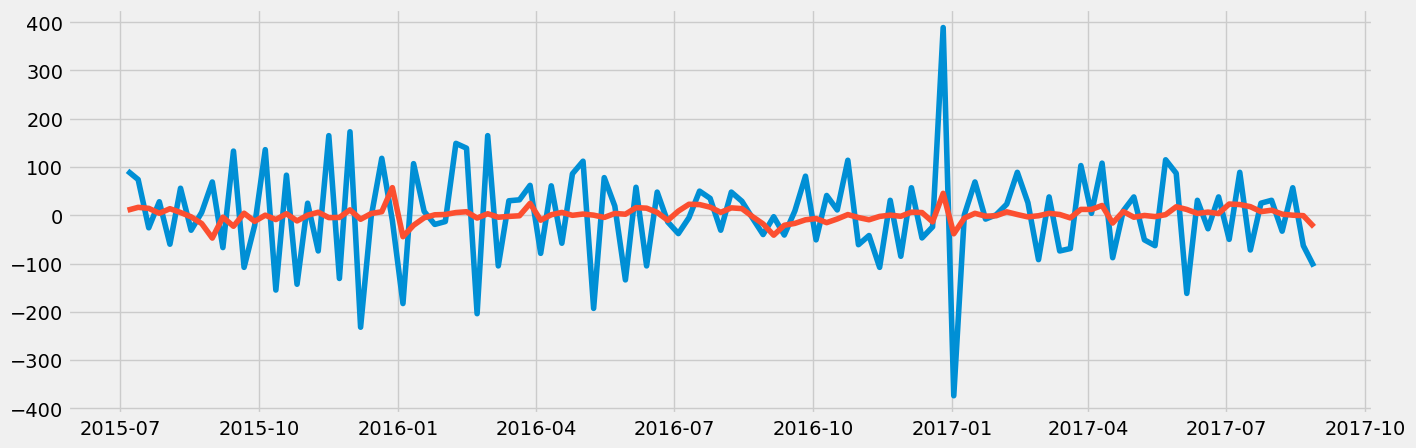

In [95]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_resort)

In [96]:
dickey_fuller(data_diff_resort['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.236383e+01
p-value                        5.470544e-23
Number of Lags Used            1.000000e+00
Number of Observations Used    1.110000e+02
Critical Value (1%)           -3.490683e+00
Critical Value (5%)           -2.887952e+00
Critical Value (10%)          -2.580857e+00
dtype: float64


In [97]:
dickey_fuller(data_diff_resort['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.066081e+00
p-value                        4.429001e-15
Number of Lags Used            0.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


In [98]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff_resort2 = data_diff_resort - data_diff_resort.shift(1) 

In [99]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff_resort2.dropna(inplace = True) 

In [100]:
data_diff_resort2.head()

,booking_count,avg_adr
date,,
2015-07-13,-18.0,5.940535
2015-07-20,-100.0,-2.107519
2015-07-27,54.0,-10.200640
2015-08-03,-88.0,9.468331
2015-08-10,116.0,-7.830132


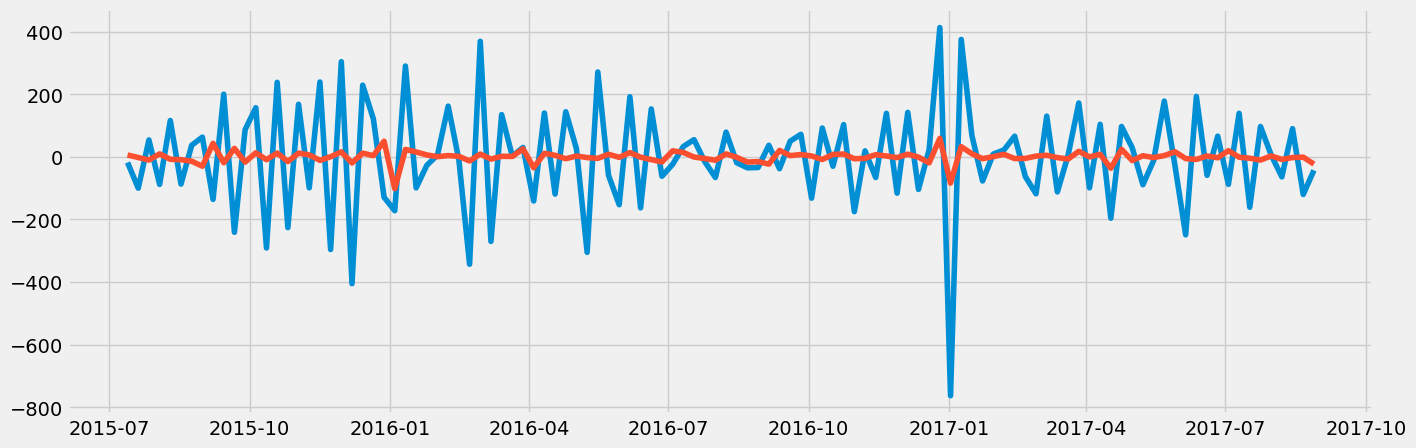

In [101]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_resort2)

In [102]:
dickey_fuller(data_diff_resort2['booking_count'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.671138e+00
p-value                        4.584733e-09
Number of Lags Used            9.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


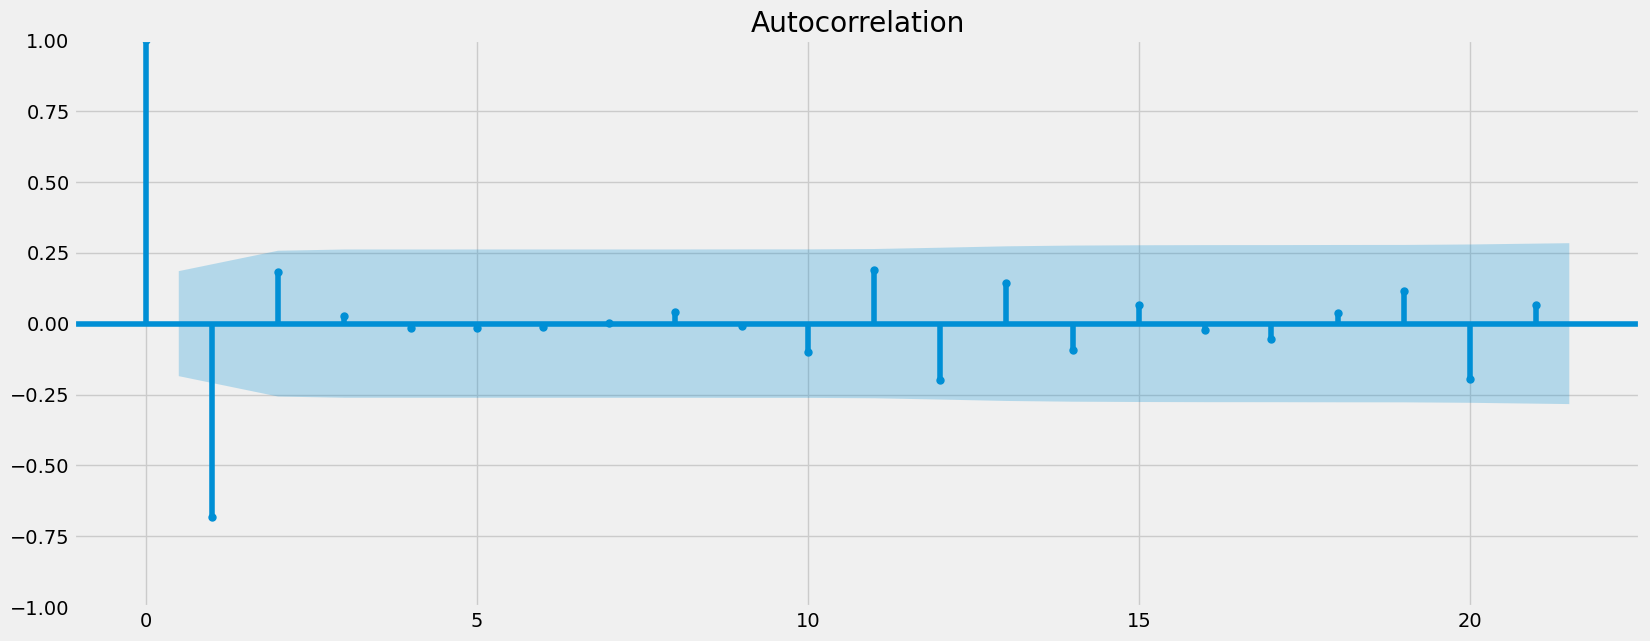

In [103]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_resort2['booking_count'])
plt.show()

In [104]:
dickey_fuller(data_diff_resort2['avg_adr'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.629961e+00
p-value                        1.622158e-16
Number of Lags Used            2.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


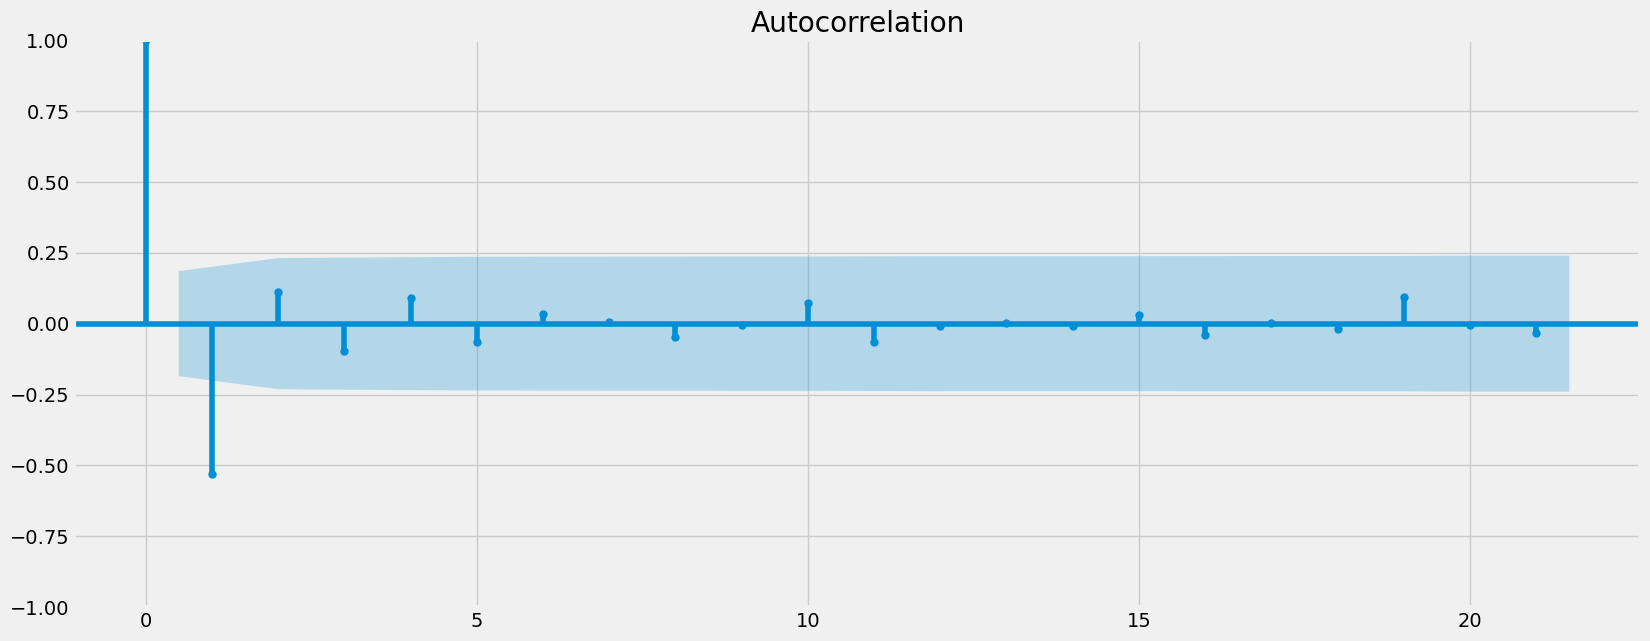

In [105]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_resort2['avg_adr'])
plt.show()

##### 
For all datasets, there had to be two rounds of differencing, as the test-statistic still was not smaller than the critical values.

# 7. Export dataframe

In [106]:
# Export dataframes
df_bookings.to_csv(os.path.join(path,'02_Data','Prepared Data', 'hotel_bookings_cleaned_wrangled_time.csv'))